In [1]:
!pip install pandas numpy gensim nltk scikit-learn matplotlib seaborn umap-learn hdbscan


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 48.2 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Set some plotting defaults
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:

movies_path = "/content/rotten_tomatoes_movies.csv"
reviews_path = "/content/rotten_tomatoes_critic_reviews.csv"

movies_raw = pd.read_csv(movies_path)
reviews_raw = pd.read_csv(reviews_path)

print("Movies shape:", movies_raw.shape)
print("Reviews shape:", reviews_raw.shape)

movies_raw.head()


Movies shape: (17712, 22)
Reviews shape: (387508, 8)


,rotten_tomatoes_link,movie_title,movie_info,critics_consensus,content_rating,genres,directors,authors,actors,original_release_date,...,production_company,tomatometer_status,tomatometer_rating,tomatometer_count,audience_status,audience_rating,audience_count,tomatometer_top_critics_count,tomatometer_fresh_critics_count,tomatometer_rotten_critics_count
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,"Always trouble-prone, the life of teenager Per...",Though it may seem like just another Harry Pot...,PG,"Action & Adventure, Comedy, Drama, Science Fic...",Chris Columbus,"Craig Titley, Chris Columbus, Rick Riordan","Logan Lerman, Brandon T. Jackson, Alexandra Da...",2010-02-12,...,20th Century Fox,Rotten,49.0,149.0,Spilled,53.0,254421.0,43,73,76
1,m/0878835,Please Give,Kate (Catherine Keener) and her husband Alex (...,Nicole Holofcener's newest might seem slight i...,R,Comedy,Nicole Holofcener,Nicole Holofcener,"Catherine Keener, Amanda Peet, Oliver Platt, R...",2010-04-30,...,Sony Pictures Classics,Certified-Fresh,87.0,142.0,Upright,64.0,11574.0,44,123,19
2,m/10,10,"A successful, middle-aged Hollywood songwriter...",Blake Edwards' bawdy comedy may not score a pe...,R,"Comedy, Romance",Blake Edwards,Blake Edwards,"Dudley Moore, Bo Derek, Julie Andrews, Robert ...",1979-10-05,...,Waner Bros.,Fresh,67.0,24.0,Spilled,53.0,14684.0,2,16,8
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),Following the closing arguments in a murder tr...,Sidney Lumet's feature debut is a superbly wri...,NR,"Classics, Drama",Sidney Lumet,Reginald Rose,"Martin Balsam, John Fiedler, Lee J. Cobb, E.G....",1957-04-13,...,Criterion Collection,Certified-Fresh,100.0,54.0,Upright,97.0,105386.0,6,54,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea","In 1866, Professor Pierre M. Aronnax (Paul Luk...","One of Disney's finest live-action adventures,...",G,"Action & Adventure, Drama, Kids & Family",Richard Fleischer,Earl Felton,"James Mason, Kirk Douglas, Paul Lukas, Peter L...",1954-01-01,...,Disney,Fresh,89.0,27.0,Upright,74.0,68918.0,5,24,3


In [7]:
reviews_raw.head()

,rotten_tomatoes_link,critic_name,top_critic,publisher_name,review_type,review_score,review_date,review_content
0,m/0814255,Andrew L. Urban,False,Urban Cinefile,Fresh,NaN,2010-02-06,A fantasy adventure that fuses Greek mythology...
1,m/0814255,Louise Keller,False,Urban Cinefile,Fresh,NaN,2010-02-06,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,False,FILMINK (Australia),Fresh,NaN,2010-02-09,With a top-notch cast and dazzling special eff...
3,m/0814255,Ben McEachen,False,Sunday Mail (Australia),Fresh,3.5/5,2010-02-09,Whether audiences will get behind The Lightnin...
4,m/0814255,Ethan Alter,True,Hollywood Reporter,Rotten,NaN,2010-02-10,What's really lacking in The Lightning Thief i...


In [41]:
# Keep only needed columns from movies
movies = movies_raw[[
    "rotten_tomatoes_link",
    "movie_title",
    "content_rating",
    "movie_info",
    "genres",
    "original_release_date"
]].copy()

# Convert release date to datetime and extract numeric year
movies["original_release_date"] = pd.to_datetime(
    movies["original_release_date"], errors="coerce"
)
movies["year"] = movies["original_release_date"].dt.year

print(movies.columns)
movies.head()


Index(['rotten_tomatoes_link', 'movie_title', 'content_rating', 'movie_info',
       'genres', 'original_release_date', 'year'],
      dtype='object')


,rotten_tomatoes_link,movie_title,content_rating,movie_info,genres,original_release_date,year
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Always trouble-prone, the life of teenager Per...","Action & Adventure, Comedy, Drama, Science Fic...",2010-02-12,2010.0
1,m/0878835,Please Give,R,Kate (Catherine Keener) and her husband Alex (...,Comedy,2010-04-30,2010.0
2,m/10,10,R,"A successful, middle-aged Hollywood songwriter...","Comedy, Romance",1979-10-05,1979.0
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),NR,Following the closing arguments in a murder tr...,"Classics, Drama",1957-04-13,1957.0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea",G,"In 1866, Professor Pierre M. Aronnax (Paul Luk...","Action & Adventure, Drama, Kids & Family",1954-01-01,1954.0


In [42]:
# Keep only needed columns from reviews
reviews = reviews_raw[[
    "rotten_tomatoes_link",
    "review_score",
    "review_content"
]].copy()

print(reviews.columns)
reviews.head()


Index(['rotten_tomatoes_link', 'review_score', 'review_content'], dtype='object')


,rotten_tomatoes_link,review_score,review_content
0,m/0814255,NaN,A fantasy adventure that fuses Greek mythology...
1,m/0814255,NaN,"Uma Thurman as Medusa, the gorgon with a coiff..."
2,m/0814255,NaN,With a top-notch cast and dazzling special eff...
3,m/0814255,3.5/5,Whether audiences will get behind The Lightnin...
4,m/0814255,NaN,What's really lacking in The Lightning Thief i...


Convert review_score to numeric

In [43]:
# Convert review_score to numeric (0–1 where possible, else NaN)
def convert_score(x):
    if pd.isna(x):
        return np.nan
    # handle formats like '3.5/5'
    if isinstance(x, str) and "/" in x:
        try:
            numerator, denominator = x.split("/")
            return float(numerator) / float(denominator)
        except Exception:
            return np.nan

    try:
        return float(x)
    except Exception:
        return np.nan

reviews["review_score"] = reviews["review_score"].apply(convert_score)
reviews["review_score"].head()


,review_score
0,NaN
1,NaN
2,NaN
3,0.7
4,NaN


Clean review text

In [44]:
# Clean review text
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # handle missing BEFORE converting to string
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""

    text = str(text).lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    tokens = [w for w in text.split() if w not in stop_words and w != "nan"]
    return " ".join(tokens)

reviews["clean_review"] = reviews["review_content"].apply(clean_text)

# Drop rows where cleaned text is empty
reviews = reviews[reviews["clean_review"].str.len() > 0].reset_index(drop=True)

reviews.head()


,rotten_tomatoes_link,review_score,review_content,clean_review
0,m/0814255,NaN,A fantasy adventure that fuses Greek mythology...,fantasy adventure fuses greek mythology contem...
1,m/0814255,NaN,"Uma Thurman as Medusa, the gorgon with a coiff...",uma thurman medusa gorgon coiffure writhing sn...
2,m/0814255,NaN,With a top-notch cast and dazzling special eff...,top notch cast dazzling special effects tide t...
3,m/0814255,0.7,Whether audiences will get behind The Lightnin...,whether audiences get behind lightning thief h...
4,m/0814255,NaN,What's really lacking in The Lightning Thief i...,really lacking lightning thief genuine sense w...


LDA Topic Modeling on reviews

In [45]:
# Tokenize
reviews["tokens"] = reviews["clean_review"].str.split()

# Build dictionary
dictionary = Dictionary(reviews["tokens"])
dictionary.filter_extremes(no_below=10, no_above=0.5)
# Build corpus
corpus = [dictionary.doc2bow(tokens) for tokens in reviews["tokens"]]

# Train LDA
num_topics = 10  # e.g., 10, 15, 20
lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    passes=5,
    random_state=42
)

print("Top words per topic:")
for i in range(num_topics):
    print(f"Topic {i}: {lda.print_topic(i)}")


Top words per topic:
Topic 0: 0.018*"film" + 0.017*"director" + 0.016*"story" + 0.007*"character" + 0.007*"work" + 0.007*"characters" + 0.007*"effects" + 0.006*"style" + 0.006*"writer" + 0.006*"old"
Topic 1: 0.011*"film" + 0.009*"drama" + 0.008*"shot" + 0.008*"man" + 0.007*"story" + 0.007*"love" + 0.007*"frozen" + 0.006*"life" + 0.006*"portrait" + 0.005*"rock"
Topic 2: 0.016*"girl" + 0.012*"since" + 0.011*"book" + 0.011*"god" + 0.010*"comic" + 0.009*"best" + 0.009*"boys" + 0.008*"classic" + 0.008*"novel" + 0.008*"performance"
Topic 3: 0.025*"well" + 0.014*"movie" + 0.012*"film" + 0.010*"worth" + 0.010*"enough" + 0.008*"entertainment" + 0.007*"comedy" + 0.006*"part" + 0.006*"story" + 0.005*"fast"
Topic 4: 0.011*"goosebumps" + 0.010*"ghost" + 0.009*"horror" + 0.008*"monsters" + 0.007*"director" + 0.007*"social" + 0.006*"moore" + 0.006*"age" + 0.006*"film" + 0.005*"documentary"
Topic 5: 0.020*"film" + 0.018*"movie" + 0.014*"like" + 0.013*"one" + 0.011*"see" + 0.010*"get" + 0.010*"much" + 

Get topic distribution for each review

In [46]:
def get_topic_vector(bow, num_topics):
    topics = lda.get_document_topics(bow, minimum_probability=0.0)
    vec = np.zeros(num_topics)
    for topic_id, prob in topics:
        vec[topic_id] = prob
    return vec


topic_vectors = [get_topic_vector(bow, num_topics) for bow in corpus]
topic_matrix = np.vstack(topic_vectors)

topic_cols = [f"topic_{i}" for i in range(num_topics)]
reviews_topics_df = pd.DataFrame(topic_matrix, columns=topic_cols)


reviews_with_topics = pd.concat(
    [reviews[["rotten_tomatoes_link", "review_score"]].reset_index(drop=True),
     reviews_topics_df],
    axis=1
)

reviews_with_topics.head()


,rotten_tomatoes_link,review_score,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,m/0814255,NaN,0.289567,0.110767,0.005007,0.005007,0.005006,0.265448,0.127340,0.084286,0.005006,0.102565
1,m/0814255,NaN,0.007723,0.007723,0.007723,0.007724,0.162002,0.493612,0.110138,0.007723,0.083746,0.111887
2,m/0814255,NaN,0.450003,0.007711,0.007710,0.007710,0.007710,0.109434,0.007711,0.205099,0.189200,0.007711
3,m/0814255,0.7,0.227038,0.004768,0.004767,0.126096,0.004767,0.186183,0.004767,0.004767,0.004767,0.432078
4,m/0814255,NaN,0.102845,0.093553,0.008364,0.130483,0.008365,0.622935,0.008363,0.008365,0.008364,0.008363


Aggregate to movie-level topic vectors

In [48]:
# Aggregate topics + scores to movie level
movie_topics = reviews_with_topics.groupby("rotten_tomatoes_link").mean().reset_index()
movie_topics.head()


,rotten_tomatoes_link,review_score,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,m/0814255,0.547356,0.250361,0.044248,0.075210,0.115484,0.055955,0.125521,0.067869,0.119030,0.063343,0.082979
1,m/0878835,0.759244,0.096306,0.040380,0.035453,0.073651,0.077658,0.300181,0.067100,0.092722,0.155969,0.060579
2,m/10,0.584091,0.053306,0.071898,0.044259,0.062002,0.129866,0.163805,0.130417,0.134353,0.122158,0.087937
3,m/1000013-12_angry_men,0.932321,0.259435,0.060322,0.092739,0.048658,0.055782,0.127533,0.065844,0.078860,0.114837,0.095990
4,m/1000079-20000_leagues_under_the_sea,0.791667,0.128303,0.048125,0.190349,0.068672,0.019348,0.156678,0.026302,0.061918,0.090107,0.210198


Encode genres (multi-hot) and merge with topics

In [51]:
# Handle missing genres
movies["genres"] = movies["genres"].fillna("")


movies["genre_list"] = movies["genres"].apply(
    lambda x: [g.strip() for g in re.split(r"[|,]", x) if g.strip()]
)


mlb = MultiLabelBinarizer()
genre_matrix = mlb.fit_transform(movies["genre_list"])
genre_cols = [f"genre_{g}" for g in mlb.classes_]
genre_df = pd.DataFrame(genre_matrix, columns=genre_cols)

movies_with_genres = pd.concat(
    [movies.reset_index(drop=True), genre_df],
    axis=1
)

movies_with_genres.head()


,rotten_tomatoes_link,movie_title,content_rating,movie_info,genres,original_release_date,year,genre_list,genre_Action & Adventure,genre_Animation,...,genre_Horror,genre_Kids & Family,genre_Musical & Performing Arts,genre_Mystery & Suspense,genre_Romance,genre_Science Fiction & Fantasy,genre_Special Interest,genre_Sports & Fitness,genre_Television,genre_Western
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Always trouble-prone, the life of teenager Per...","Action & Adventure, Comedy, Drama, Science Fic...",2010-02-12,2010.0,"[Action & Adventure, Comedy, Drama, Science Fi...",1,0,...,0,0,0,0,0,1,0,0,0,0
1,m/0878835,Please Give,R,Kate (Catherine Keener) and her husband Alex (...,Comedy,2010-04-30,2010.0,[Comedy],0,0,...,0,0,0,0,0,0,0,0,0,0
2,m/10,10,R,"A successful, middle-aged Hollywood songwriter...","Comedy, Romance",1979-10-05,1979.0,"[Comedy, Romance]",0,0,...,0,0,0,0,1,0,0,0,0,0
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),NR,Following the closing arguments in a murder tr...,"Classics, Drama",1957-04-13,1957.0,"[Classics, Drama]",0,0,...,0,0,0,0,0,0,0,0,0,0
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea",G,"In 1866, Professor Pierre M. Aronnax (Paul Luk...","Action & Adventure, Drama, Kids & Family",1954-01-01,1954.0,"[Action & Adventure, Drama, Kids & Family]",1,0,...,0,1,0,0,0,0,0,0,0,0


In [52]:
# Merge movies (with genres + year) and movie_topics (topics + review_score)
movie_level = movies_with_genres.merge(
    movie_topics,
    on="rotten_tomatoes_link",
    how="inner"
)

print("movie_level shape:", movie_level.shape)
movie_level.head()


movie_level shape: (7216, 40)


,rotten_tomatoes_link,movie_title,content_rating,movie_info,genres,original_release_date,year,genre_list,genre_Action & Adventure,genre_Animation,...,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9
0,m/0814255,Percy Jackson & the Olympians: The Lightning T...,PG,"Always trouble-prone, the life of teenager Per...","Action & Adventure, Comedy, Drama, Science Fic...",2010-02-12,2010.0,"[Action & Adventure, Comedy, Drama, Science Fi...",1,0,...,0.250361,0.044248,0.075210,0.115484,0.055955,0.125521,0.067869,0.119030,0.063343,0.082979
1,m/0878835,Please Give,R,Kate (Catherine Keener) and her husband Alex (...,Comedy,2010-04-30,2010.0,[Comedy],0,0,...,0.096306,0.040380,0.035453,0.073651,0.077658,0.300181,0.067100,0.092722,0.155969,0.060579
2,m/10,10,R,"A successful, middle-aged Hollywood songwriter...","Comedy, Romance",1979-10-05,1979.0,"[Comedy, Romance]",0,0,...,0.053306,0.071898,0.044259,0.062002,0.129866,0.163805,0.130417,0.134353,0.122158,0.087937
3,m/1000013-12_angry_men,12 Angry Men (Twelve Angry Men),NR,Following the closing arguments in a murder tr...,"Classics, Drama",1957-04-13,1957.0,"[Classics, Drama]",0,0,...,0.259435,0.060322,0.092739,0.048658,0.055782,0.127533,0.065844,0.078860,0.114837,0.095990
4,m/1000079-20000_leagues_under_the_sea,"20,000 Leagues Under The Sea",G,"In 1866, Professor Pierre M. Aronnax (Paul Luk...","Action & Adventure, Drama, Kids & Family",1954-01-01,1954.0,"[Action & Adventure, Drama, Kids & Family]",1,0,...,0.128303,0.048125,0.190349,0.068672,0.019348,0.156678,0.026302,0.061918,0.090107,0.210198


repare numeric features & build X safely (no lists!)

In [54]:
from sklearn.preprocessing import StandardScaler

# Numeric columns
numeric_cols = ["review_score", "year"]
for col in numeric_cols:
    if col not in movie_level.columns:
        print(f"WARNING: {col} not found in data, creating as NaN.")
        movie_level[col] = np.nan

movie_level[numeric_cols] = movie_level[numeric_cols].astype(float)
movie_level[numeric_cols] = movie_level[numeric_cols].fillna(movie_level[numeric_cols].mean())


scaler = StandardScaler()
movie_level[numeric_cols] = scaler.fit_transform(movie_level[numeric_cols])


topic_cols = [c for c in movie_level.columns if c.startswith("topic_")]


genre_cols = [c for c in movie_level.columns if c.startswith("genre_")]




candidate_cols = genre_cols + numeric_cols + topic_cols


feature_cols = [c for c in candidate_cols if movie_level[c].dtype != "O"]

print("Final feature columns used:", feature_cols)

# Build numeric feature matrix and title array
X = movie_level[feature_cols].values
movie_titles = movie_level["movie_title"].values

print("Feature matrix shape:", X.shape)


Final feature columns used: ['genre_Action & Adventure', 'genre_Animation', 'genre_Anime & Manga', 'genre_Art House & International', 'genre_Classics', 'genre_Comedy', 'genre_Cult Movies', 'genre_Documentary', 'genre_Drama', 'genre_Faith & Spirituality', 'genre_Gay & Lesbian', 'genre_Horror', 'genre_Kids & Family', 'genre_Musical & Performing Arts', 'genre_Mystery & Suspense', 'genre_Romance', 'genre_Science Fiction & Fantasy', 'genre_Special Interest', 'genre_Sports & Fitness', 'genre_Television', 'genre_Western', 'review_score', 'year', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9']
Feature matrix shape: (7216, 33)


Build hybrid feature matrix

In [55]:
def get_similar_movies(title, top_k=5):
    indices = np.where(movie_titles == title)[0]
    if len(indices) == 0:
        print(f"Movie '{title}' not found.")
        return []
    idx = indices[0]

    sims = cosine_similarity(X[idx:idx+1], X)[0]
    sorted_idx = np.argsort(-sims)
    sorted_idx = sorted_idx[sorted_idx != idx]

    results = []
    for i in sorted_idx[:top_k]:
        results.append({
            "movie_title": movie_titles[i],
            "similarity": float(sims[i]),
            "index": int(i)
        })
    return results


In [59]:
print("Columns in movie_level:")
print(movie_level.columns.tolist())


Columns in movie_level:
['rotten_tomatoes_link', 'movie_title', 'content_rating', 'movie_info', 'genres', 'original_release_date', 'year', 'genre_Action & Adventure', 'genre_Animation', 'genre_Anime & Manga', 'genre_Art House & International', 'genre_Classics', 'genre_Comedy', 'genre_Cult Movies', 'genre_Documentary', 'genre_Drama', 'genre_Faith & Spirituality', 'genre_Gay & Lesbian', 'genre_Horror', 'genre_Kids & Family', 'genre_Musical & Performing Arts', 'genre_Mystery & Suspense', 'genre_Romance', 'genre_Science Fiction & Fantasy', 'genre_Special Interest', 'genre_Sports & Fitness', 'genre_Television', 'genre_Western', 'review_score', 'topic_0', 'topic_1', 'topic_2', 'topic_3', 'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9']


In [60]:
print("Sample movie titles:")
sample_titles = movie_level["movie_title"].dropna().sample(10).tolist()
for t in sample_titles:
    print("-", t)


Sample movie titles:
- Aziz Ansari: Live At Madison Square Garden
- Fading Gigolo
- Cesar Chavez
- Born Into Brothels
- El Nino Pez (The Fish Child)
- Bright Eyes
- From Dusk Till Dawn
- Age of the Dragons
- Cheech and Chong's Nice Dreams
- Auntie Mame


In [70]:
def print_similar_movies(title, top_k=5):
    results = get_similar_movies(title, top_k)
    if not results:
        return

    print(f"\n Similar Movies to **{title}**\n")
    print("| Rank | Movie Title | Similarity |")
    print("|------|-------------|------------|")

    for idx, item in enumerate(results, start=1):
        print(f"| {idx} | {item['movie_title']} | {item['similarity']:.4f} |")
print_similar_movies("Bright Eyes", top_k=5)



 Similar Movies to **Bright Eyes**

| Rank | Movie Title | Similarity |
|------|-------------|------------|
| 1 | Captain January | 0.9647 |
| 2 | Going My Way | 0.9329 |
| 3 | Something to Sing About | 0.9195 |
| 4 | The Band Wagon | 0.9072 |
| 5 | A Hole in the Head | 0.9065 |


Get topic % distribution for a selected movie

In [72]:
def get_movie_topic_profile(title):
    row = movie_level[movie_level["movie_title"] == title]
    if row.empty:
        print(f"Movie '{title}' not found.")
        return None
    topic_vals = row[topic_cols].values[0]
    return dict(zip(topic_cols, topic_vals))

alien_topics = get_movie_topic_profile("Alien")
alien_topics


{'topic_0': np.float64(0.14139779823599383),
 'topic_1': np.float64(0.08863006246586641),
 'topic_2': np.float64(0.041821566456928846),
 'topic_3': np.float64(0.09121877323874893),
 'topic_4': np.float64(0.12526221533383552),
 'topic_5': np.float64(0.13337019506531458),
 'topic_6': np.float64(0.04892887681101759),
 'topic_7': np.float64(0.10247100245129938),
 'topic_8': np.float64(0.06925836683173353),
 'topic_9': np.float64(0.1576411475117008)}

Clustering movies (KMeans)

In [73]:
k = 10  # number of clusters
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
movie_level["cluster"] = kmeans.fit_predict(X)

movie_level[["movie_title", "cluster"]].head()


,movie_title,cluster
0,Percy Jackson & the Olympians: The Lightning T...,4
1,Please Give,4
2,10,2
3,12 Angry Men (Twelve Angry Men),9
4,"20,000 Leagues Under The Sea",9


inspect movies in the same cluster

In [74]:
cluster_id = 0
movie_level[movie_level["cluster"] == cluster_id][["movie_title", "genres"]].head(20)


,movie_title,genres
24,Whore,"Art House & International, Drama"
27,A Tale of Two Pizzas,Comedy
29,Going the Distance,Comedy
30,Ultraviolet,"Action & Adventure, Drama, Horror, Science Fic..."
54,The Mostly Unfabulous Social Life of Ethan Green,"Comedy, Drama"
56,Stay Alive,"Horror, Mystery & Suspense"
76,Snow Blind,"Documentary, Sports & Fitness"
83,American Anthem,"Action & Adventure, Documentary, Drama"
100,Day of the Dead,"Horror, Mystery & Suspense"
101,My Best Friend's Girl,"Comedy, Drama"


Genre distribution (bar chart)

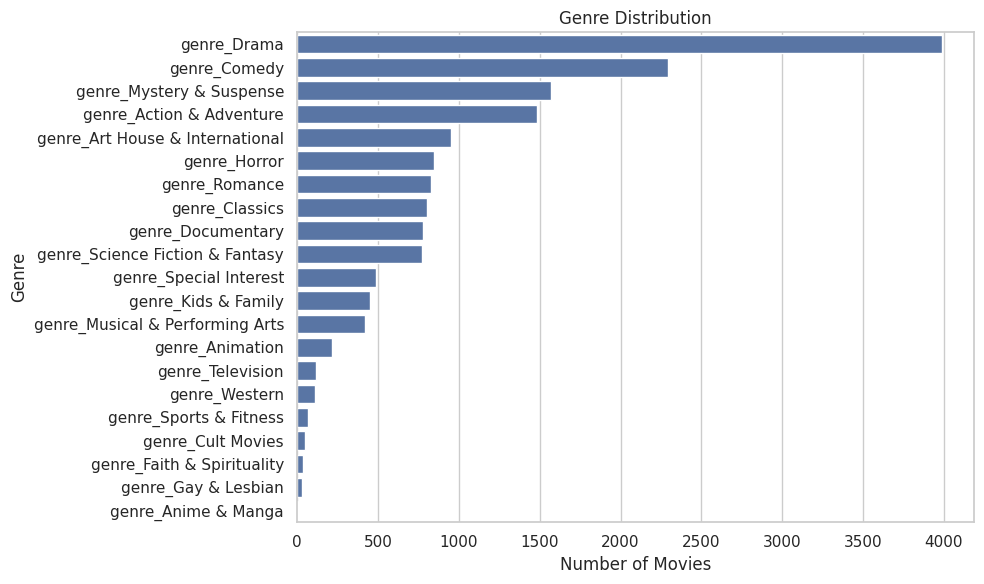

In [75]:
genre_sums = movie_level[genre_cols].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=genre_sums.values, y=genre_sums.index)
plt.title("Genre Distribution")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


Review score distribution (histogram)

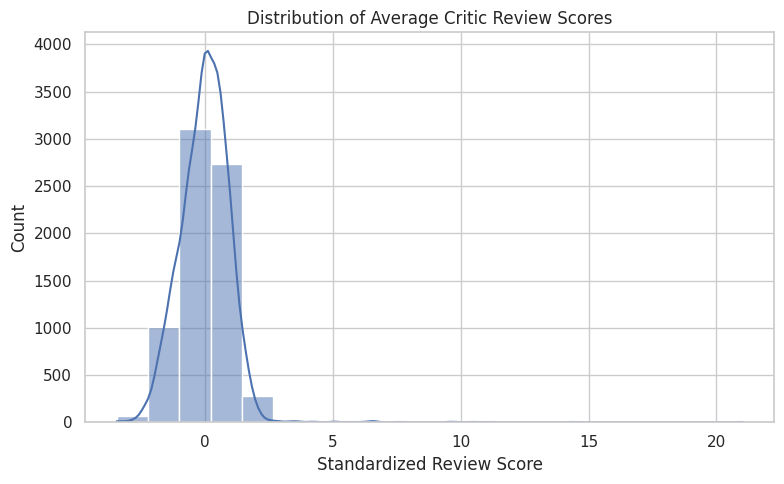

In [76]:
plt.figure(figsize=(8, 5))
sns.histplot(movie_level["review_score"], bins=20, kde=True)
plt.title("Distribution of Average Critic Review Scores")
plt.xlabel("Standardized Review Score")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


Genre vs review score (boxplot)

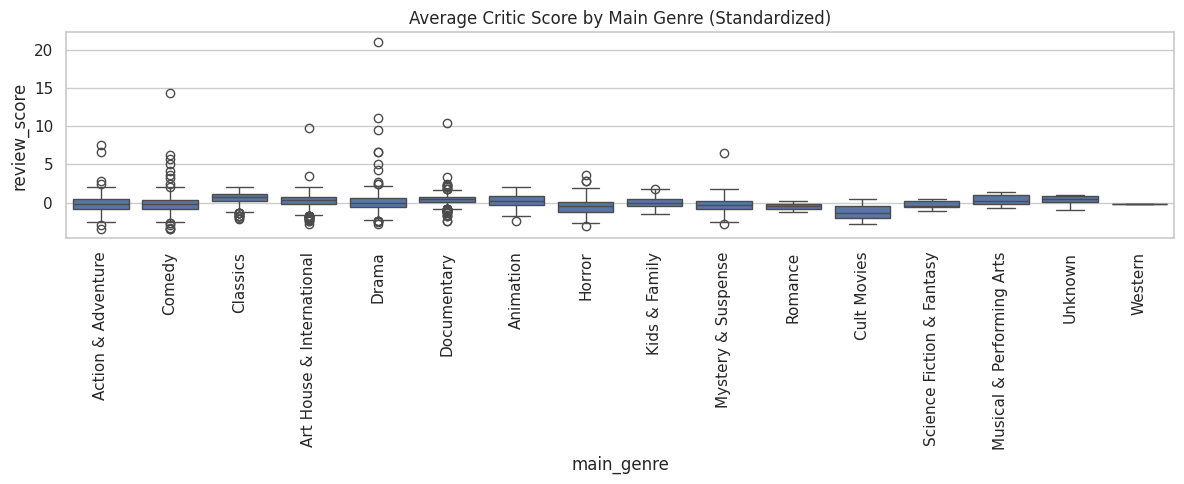

In [81]:
import re

def extract_main_genre_from_genres(genres):
    if pd.isna(genres) or not str(genres).strip():
        return "Unknown"
    parts = re.split(r"[|,]", str(genres))
    first = parts[0].strip()
    return first if first else "Unknown"

movie_level["main_genre"] = movie_level["genres"].apply(extract_main_genre_from_genres)
plt.figure(figsize=(12, 5))
sns.boxplot(
    x="main_genre",
    y="review_score",
    data=movie_level
)
plt.xticks(rotation=90)
plt.title("Average Critic Score by Main Genre (Standardized)")
plt.tight_layout()
plt.show()


Topic composition of a given movie (pie chart)

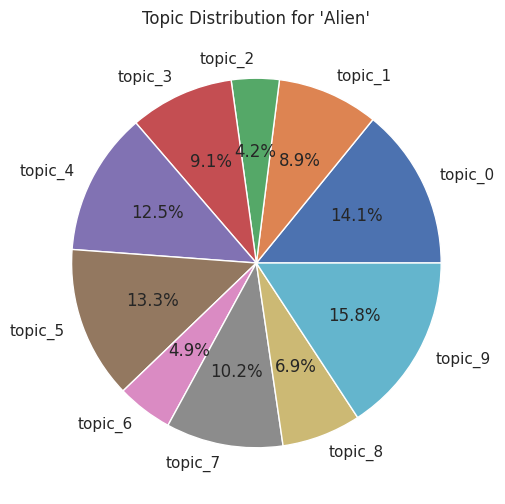

In [78]:
def plot_movie_topic_pie(title):
    profile = get_movie_topic_profile(title)
    if profile is None:
        return
    labels = list(profile.keys())
    sizes = list(profile.values())

    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%')
    plt.title(f"Topic Distribution for '{title}'")
    plt.show()

plot_movie_topic_pie("Alien")  # change movie


Similarity bar chart for recommended movies

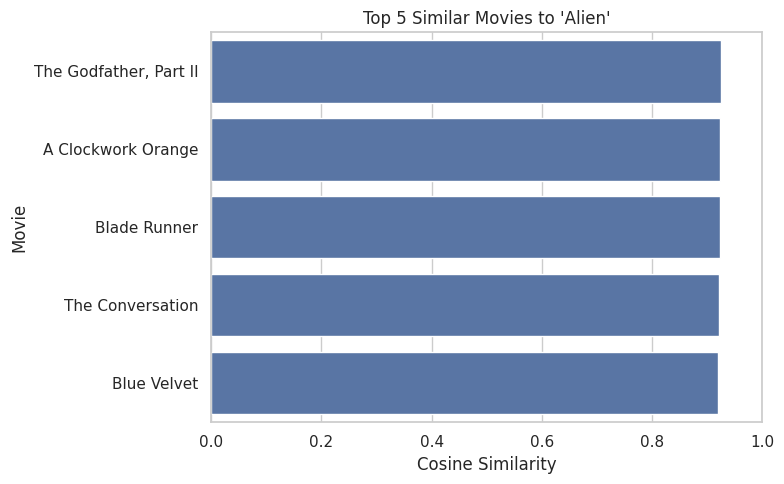

In [79]:
def plot_similar_movies(title, top_k=5):
    sims = get_similar_movies(title, top_k=top_k)
    if not sims:
        return
    titles = [d["movie_title"] for d in sims]
    scores = [d["similarity"] for d in sims]

    plt.figure(figsize=(8, 5))
    sns.barplot(x=scores, y=titles)
    plt.title(f"Top {top_k} Similar Movies to '{title}'")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Movie")
    plt.xlim(0, 1)
    plt.tight_layout()
    plt.show()

plot_similar_movies("Alien", top_k=5)


Similarity heatmap for a small subset

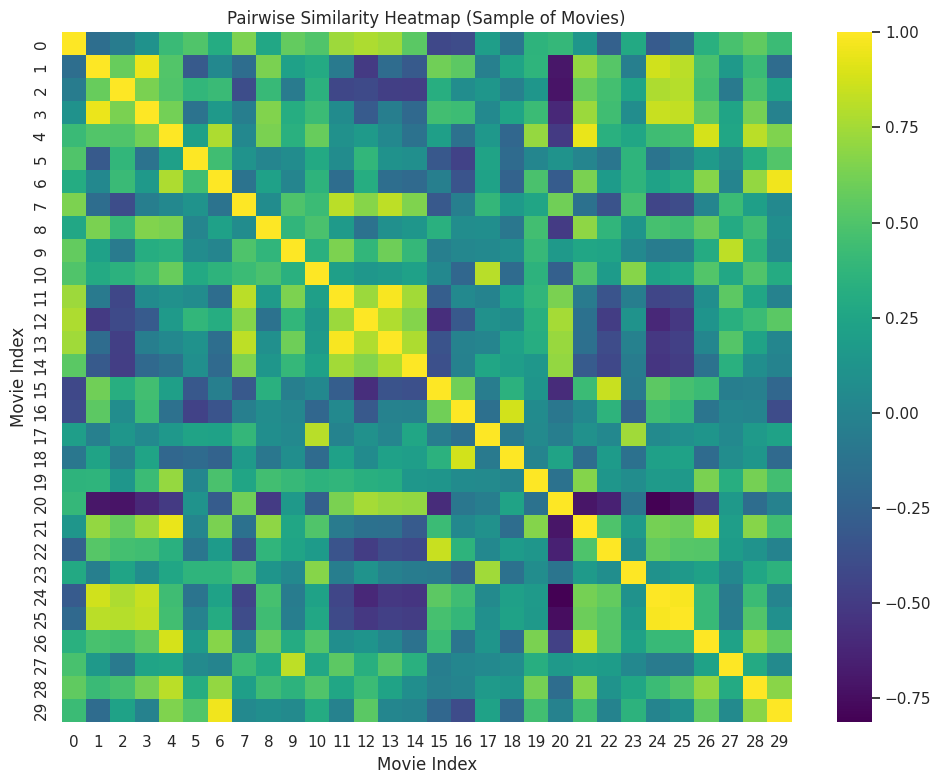

In [80]:
# Take a sample of N movies
N = 30
sample = movie_level.sample(N, random_state=42).reset_index(drop=True)
X_sample = sample[feature_cols].values

sim_matrix = cosine_similarity(X_sample, X_sample)

plt.figure(figsize=(10, 8))
sns.heatmap(sim_matrix, cmap="viridis")
plt.title("Pairwise Similarity Heatmap (Sample of Movies)")
plt.xlabel("Movie Index")
plt.ylabel("Movie Index")
plt.tight_layout()
plt.show()
